# Scanpy: Quality control

#DATA_TITLE:

#DATA_ALL1:


In [1]:
# create a data directory.
!mkdir -p data

# check if file exists before downloading it.
!if [ ! -f data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v2/pbmc_1k_v2_filtered_feature_bc_matrix.h5; fi

!if [ ! -f data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5; fi

!if [ ! -f data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5; fi

#DATA_ALL2:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()


/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2


In [3]:
sc.settings.set_figure_params(dpi=80)

#DATA_ALL3:

In [4]:
data_p3 = sc.read_10x_h5(
    './data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5', gex_only = True)  
# OBS! gex_only to only read gene expression data.
data_p3.var_names_make_unique()

data_v2 = sc.read_10x_h5(
    './data/pbmc_1k_v2_filtered_feature_bc_matrix.h5')
data_v2.var_names_make_unique()

data_v3 = sc.read_10x_h5(
    './data/pbmc_1k_v3_filtered_feature_bc_matrix.h5')
data_v3.var_names_make_unique()


reading ./data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./data/pbmc_1k_v2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./data/pbmc_1k_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


#OBJ_TITLE:

In [5]:
# first add in batch info in metadata
data_v2.obs['lib_prep'] = 'v2'
data_v3.obs['lib_prep'] = 'v3'
data_p3.obs['lib_prep'] = 'p3'


# merge into one object
adata = data_v2.concatenate(data_v3, data_p3)

# and delete individual datasets to save space
del(data_v2)
del(data_v3)
del(data_p3)


Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


#OBJ_SCRANPY:

In [6]:
print(adata.obs['lib_prep'].value_counts())

adata

v3    1222
v2     996
p3     713
Name: lib_prep, dtype: int64


AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep'
    var: 'gene_ids', 'feature_types', 'genome'

#QC_TITLE:

#QC_ALL1:

#QC_ALL1.1:

#QC_1_SCANPY:


In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

# we now have many additional data types in the obs slot:
adata

AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

#QC_2_SCANPY:

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

print(sum(mito_genes))

13


#QC_ALL2: 

In [9]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1



104


#QC_2_SCANPY:

In [10]:
adata

AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

#QC_TITLE2:

#QC_ALL3:

... storing 'lib_prep' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


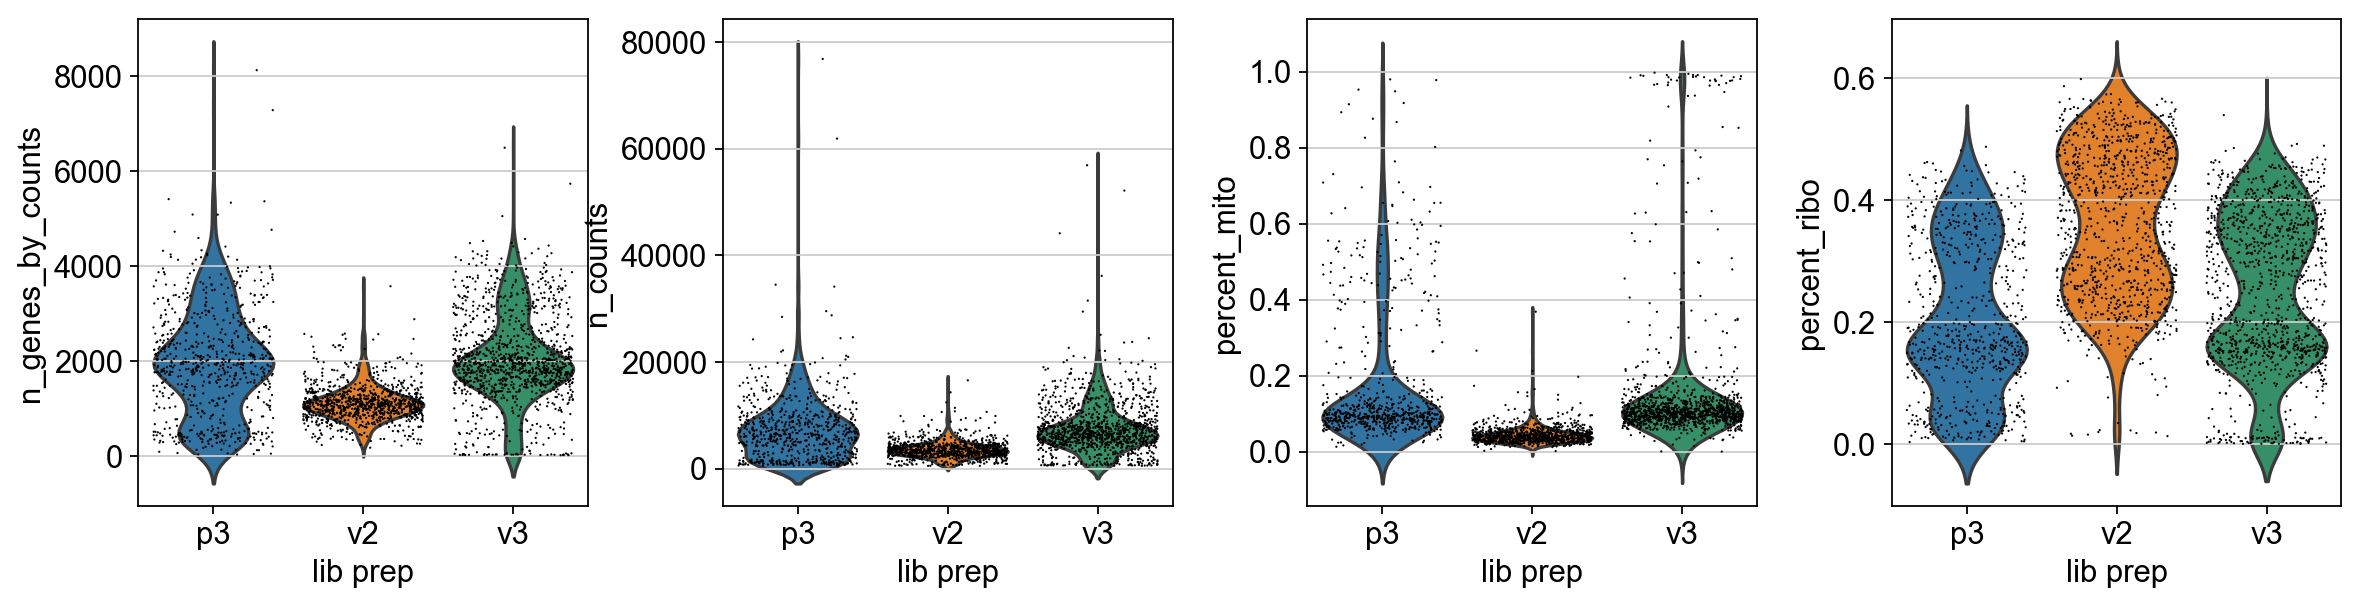

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

#QC_ALL4:


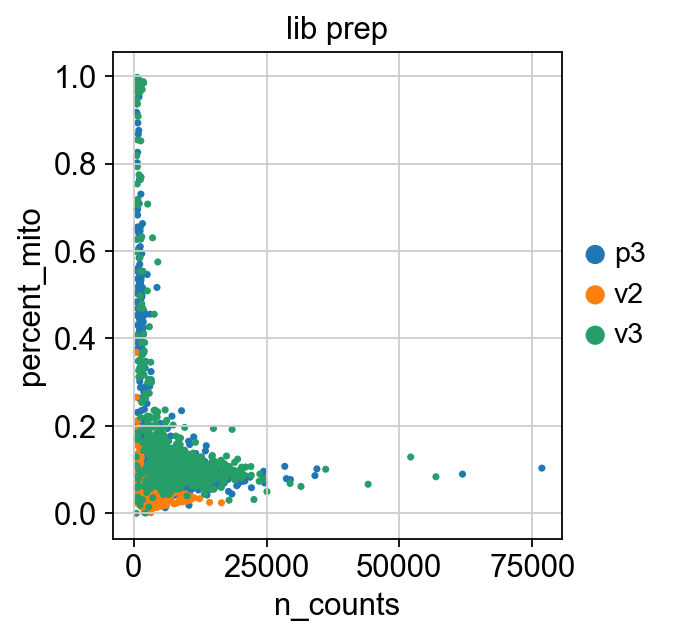

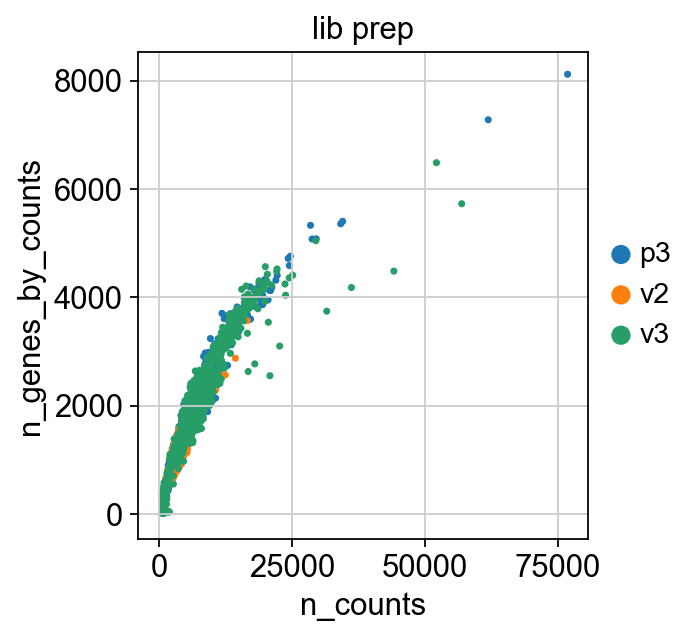

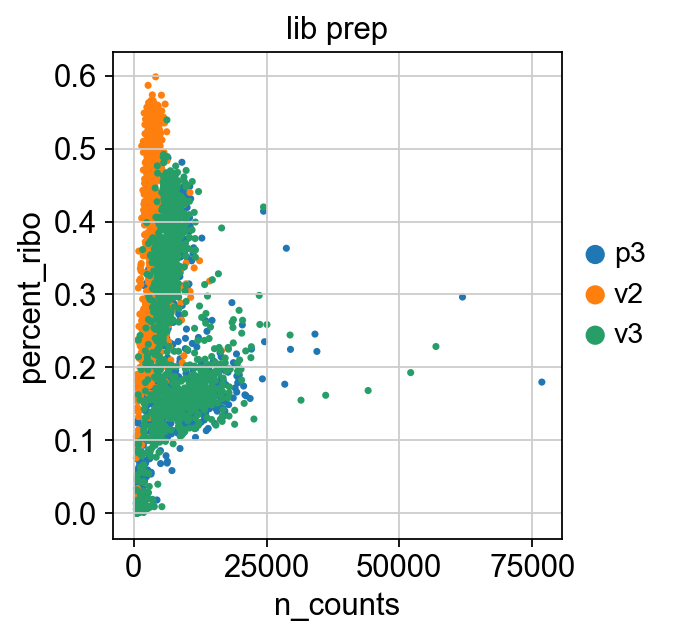

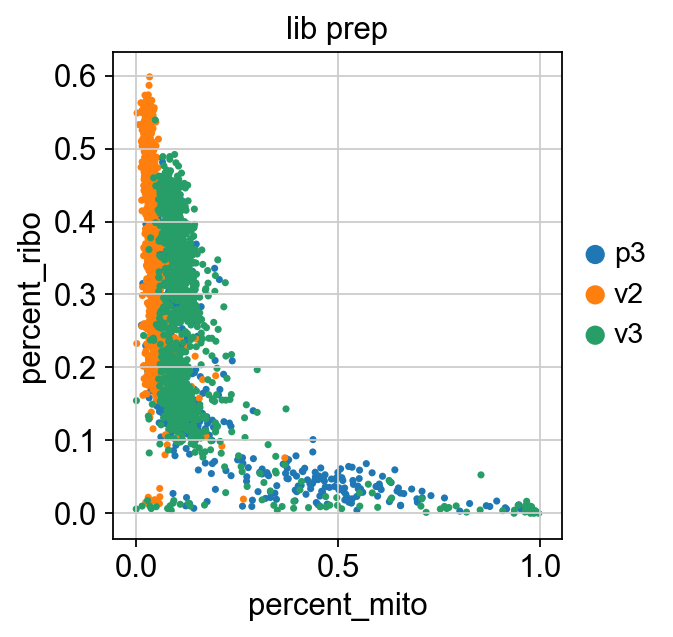

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="lib_prep")
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="lib_prep")

#FILTERING_TITLE:

#FILTERING_ALL0:


In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 62 cells that haveless than 200 genes expressed
filtered out 16758 genes that are detectedin less than 3 cells


#FILTERING_ALL3:

In [14]:
# filter for gene detection for v2
keep_v2 = (adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 500) & (adata.obs['lib_prep'] == 'v2')
print(sum(keep_v2))

# filter for gene detection for v3
keep_v3 = (adata.obs['n_genes_by_counts'] < 4100) & (adata.obs['n_genes_by_counts'] > 1000) & (adata.obs['lib_prep'] != 'v2')
print(sum(keep_v3))

# keep both sets of cells
keep = (keep_v2) | (keep_v3)
print(sum(keep))
adata = adata[keep, :]


933
1608
2541


#FILTERING_ALL01:


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


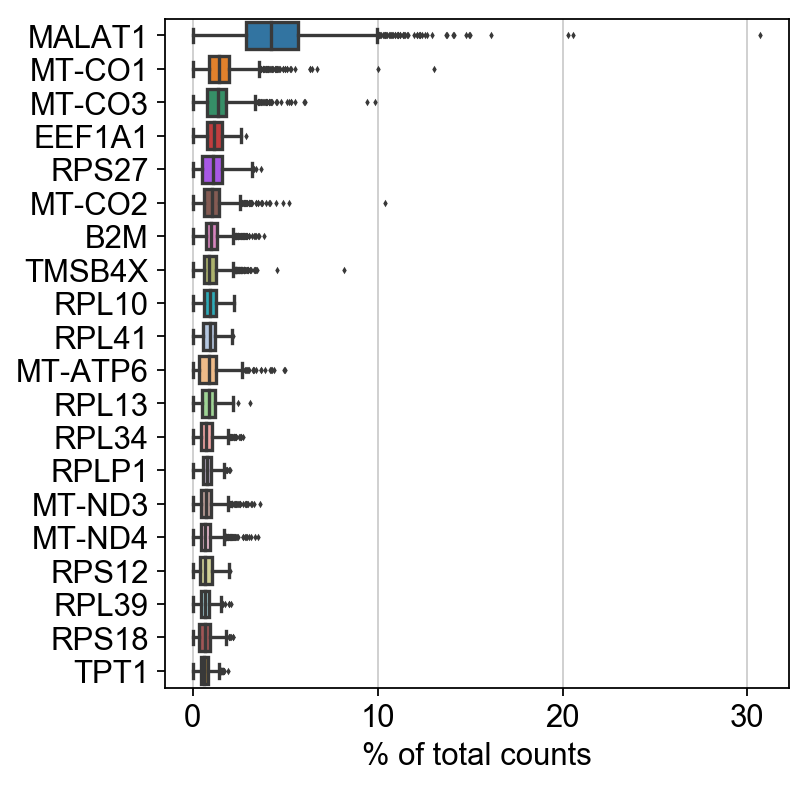

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

#FILTERING_ALL02:

#FILTERING_TITLE2:

#FILTERING_ALL1:

In [16]:
# filter for percent mito
adata = adata[adata.obs['percent_mito'] < 0.25, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['percent_ribo'] > 0.05, :]


#FILTERING_ALL2:

#FILTERING_TITLE4:

#FILTERING_ALL5:

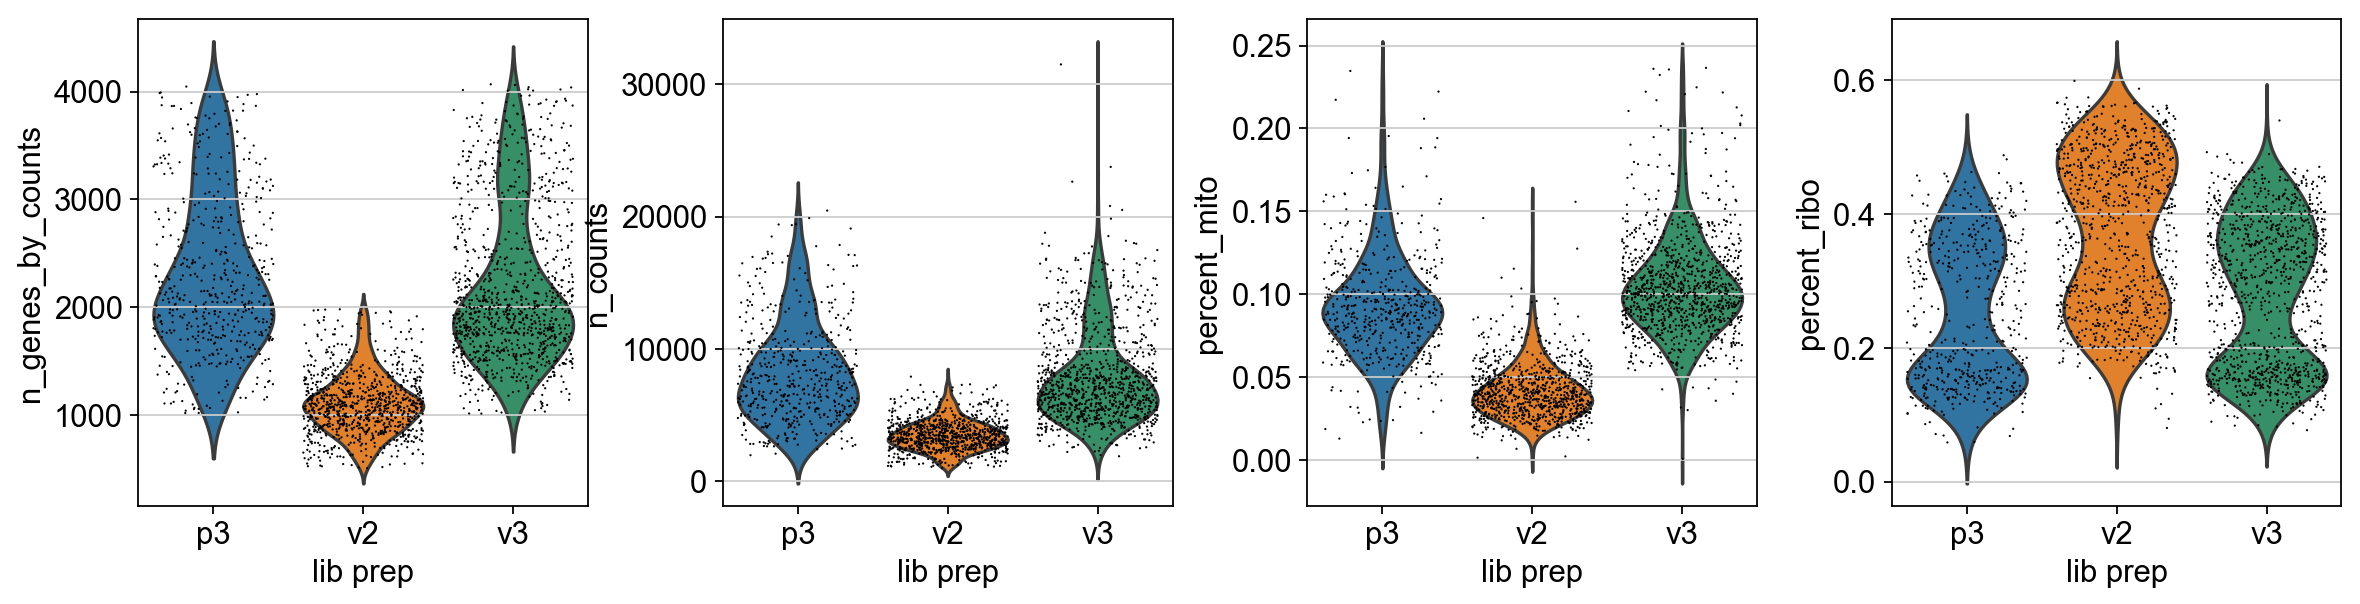

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

#FILTERING_TITLE5:

#FILTERING_ALL6:

In [18]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]


In [19]:
adata

View of AnnData object with n_obs × n_vars = 2527 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'lib_prep_colors'

#CELLCYCLE_TITLE:

#CELLCYCLE_ALL1:

#CELLCYCLE_1_SCANPY:


In [20]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi
    

In [21]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
90


#CELLCYCLE_2_SCANPY: 

In [22]:
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#CELLCYCLE_3_SCANPY: 

In [23]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


#CELLCYCLE_ALL2:

... storing 'phase' as categorical


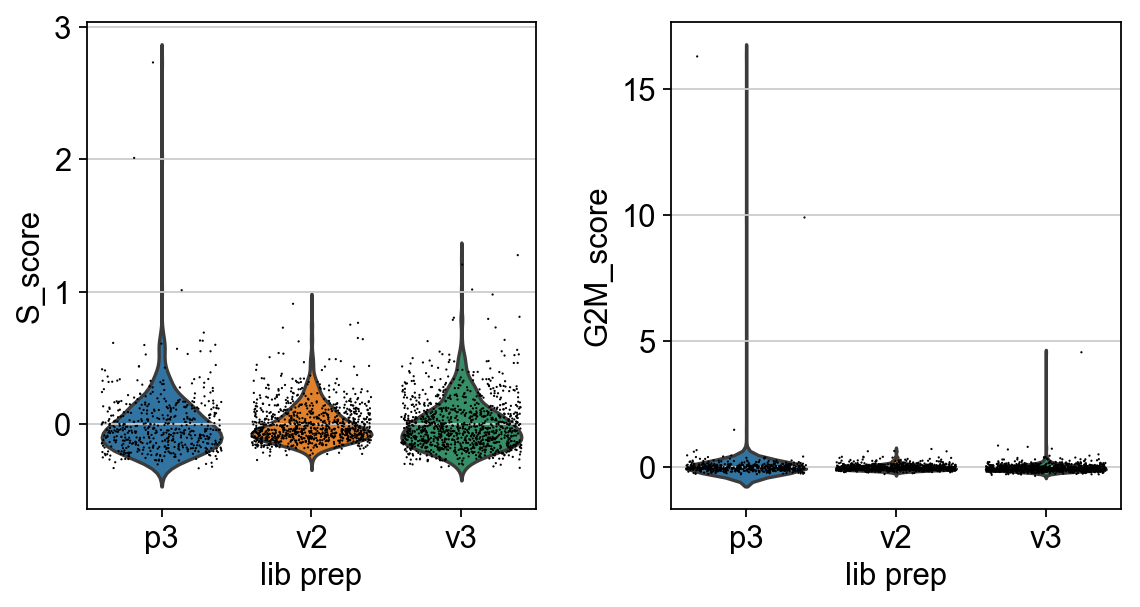

In [24]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'lib_prep')

#CELLCYCLE_ALL3:

#CELLCYCLE_ALL4:

#CELLCYCLE_ALL5:

In [25]:
save_file = 'data/scanpy_qc_filtered_3pbmc.h5ad'
adata.write_h5ad(save_file)